This notebook produces the inhibition curve analysis shown in figure 5, the ic50 values of isolated mutants in salt, and associated supplemental materials.

In [39]:
#setup
import os
import pandas as pd
import string
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import curve_fit



pwd = os.getcwd()
pwd_minus_one = os.path.dirname(pwd)   # one level up
data_dir = os.path.join(pwd, "biobloomrxiv_source_data", "inhibition_curves")

fig_out = os.path.join(pwd_minus_one, "figures", 'fig5')

num_plates = 6

In [1]:
### import endpoint OD data from growth experiments, plate reader data
# Prepare list to collect each tidy dataframe
tidy_plates = []

# Loop through files
for i in list(range(1, num_plates+1)):
    filename = f"endpoint_p{i}.txt"
    filepath = os.path.join(data_dir, filename)

    df = pd.read_csv(filepath, sep='\t', header=None)
    
    # Assign row and column labels
    df.index = list(string.ascii_uppercase[:8])  # A to H
    df.columns = range(1, 13)                    # 1 to 12

    # Tidy it up
    tidy_df = df.stack().reset_index()
    tidy_df.columns = ['row', 'column', 'OD']
    tidy_df['well'] = tidy_df['row'] + tidy_df['column'].astype(str)
    tidy_df.drop(columns = ['row', 'column'],inplace=True)

    # Add plate number
    tidy_df['plate'] = i

    # Collect
    tidy_plates.append(tidy_df)

# Concatenate all into one final dataframe
all_data = pd.concat(tidy_plates, ignore_index=True)

all_data['true_OD'] = all_data['OD'] * 3 ## 3x dilution

NameError: name 'num_plates' is not defined

In [57]:
all_data

,OD,well,plate,true_OD
0,0.8950,A1,1,2.6850
1,0.7170,A2,1,2.1510
2,0.8498,A3,1,2.5494
3,0.7953,A4,1,2.3859
4,0.6719,A5,1,2.0157
...,...,...,...,...
571,0.3916,H8,6,1.1748
572,0.2122,H9,6,0.6366
573,0.0887,H10,6,0.2661
574,0.0615,H11,6,0.1845


In [42]:
#upload strain metadata

# Prepare list to collect each tidy dataframe
tidy_plates = []

# Loop through files
for i in list(range(1, num_plates+1)):
    filename = f"strains_p"+str(i)+".txt"
    filepath = os.path.join(data_dir, filename)

    df = pd.read_csv(filepath, sep='\t', header=None)
    
    # Assign row and column labels
    df.index = list(string.ascii_uppercase[:8])  # A to H
    df.columns = range(1, 13)                    # 1 to 12

    # Tidy it up
    tidy_df = df.stack().reset_index()
    tidy_df.columns = ['row', 'column', 'strain']
    tidy_df['well'] = tidy_df['row'] + tidy_df['column'].astype(str)
    tidy_df.drop(columns = ['row', 'column'],inplace=True)

    # Add plate number
    tidy_df['plate'] = i

    # Collect
    tidy_plates.append(tidy_df)

# Concatenate all into one final dataframe
strain_data = pd.concat(tidy_plates, ignore_index=True)

In [43]:
strain_data

,strain,well,plate
0,s.Ek.E.01387,A1,1
1,s.Ek.E.01387,A2,1
2,s.Ek.E.01387,A3,1
3,s.Ek.E.01387,A4,1
4,s.Ek.E.01387,A5,1
...,...,...,...
571,s.Ek.E.01396,H8,6
572,s.Ek.E.01396,H9,6
573,s.Ek.E.01396,H10,6
574,s.Ek.E.01396,H11,6


In [44]:
#get salt concentrations

# Prepare list to collect each tidy dataframe
tidy_plates = []

# Loop through files
for i in list(range(1, num_plates+1)):
    filename = f"salt_metadata.txt"
    filepath = os.path.join(data_dir, filename)

    df = pd.read_csv(filepath, sep='\t', header=None)
    
    # Assign row and column labels
    df.index = list(string.ascii_uppercase[:8])  # A to H
    df.columns = range(1, 13)                    # 1 to 12

    # Tidy it up
    tidy_df = df.stack().reset_index()
    tidy_df.columns = ['row', 'column', 'added_salt_pct']
    tidy_df['well'] = tidy_df['row'] + tidy_df['column'].astype(str)
    tidy_df.drop(columns = ['row', 'column'],inplace=True)

    # Add plate number
    tidy_df['plate'] = i

    # Collect
    tidy_plates.append(tidy_df)

# Concatenate all into one final dataframe
salt_data = pd.concat(tidy_plates, ignore_index=True)

In [45]:
salt_data

,added_salt_pct,well,plate
0,0.0,A1,1
1,2.0,A2,1
2,3.0,A3,1
3,3.5,A4,1
4,4.0,A5,1
...,...,...,...
571,5.5,H8,6
572,6.0,H9,6
573,6.5,H10,6
574,7.0,H11,6


In [88]:
#import strain label metadata
strainlabels = pd.read_csv(os.path.join(data_dir, "strainlabels.csv"))
strainlabels

,strain,label
0,s.Ek.E.01387,hflK*
1,s.Ek.E.01388,mepM*1
2,s.Ek.E.01389,K-12 BioBloom parent
3,s.Ek.E.01390,hflX*
4,s.Ek.E.01391,not tested
5,s.Ek.E.01392,hsdR_mrr_intergenic*
6,s.Ek.E.01393,yidk*
7,s.Ek.E.01394,mepM_upstream
8,s.Ek.E.01395,hflC*
9,s.Ek.E.01396,mepM*2


In [65]:
#specify_strains, specify salt conditions, add strain metadata
annotated_df = pd.merge(all_data, strain_data, on = ['plate', 'well'])
print(annotated_df.shape)
annotated_df = pd.merge(annotated_df, salt_data, on = ['plate', 'well'])
print(annotated_df.shape)
annotated_df = pd.merge(annotated_df, strainlabels, on = ['strain'])
print(annotated_df.shape)

#label innoculum condition, based on plate number
annotated_df['innoculum'] = np.where(annotated_df['plate'].isin([1, 2, 3]), 'LB_innoc', 'LB+2pct_innoc') #first 3 plates regular, then preconditioned

#LB has 1% salt, display total salt
annotated_df['total_salt_pct'] = annotated_df['added_salt_pct'] + 1

#exploring the data
#into_plot
annotated_df[annotated_df['innoculum']=="LB+2pct_innoc"]

annotated_df['label'].unique()


(576, 5)
(576, 6)
(576, 7)


array(['hflK*', 'mepM*1', 'K-12 + 6.2kb HGT hit plasmid', 'K-12 parent',
       'K-12 BioBloom parent', 'hflX*', 'hsdR_mrr_intergenic*', 'mepM*2',
       'yidk*', 'mepM_upstream', 'hflC*'], dtype=object)

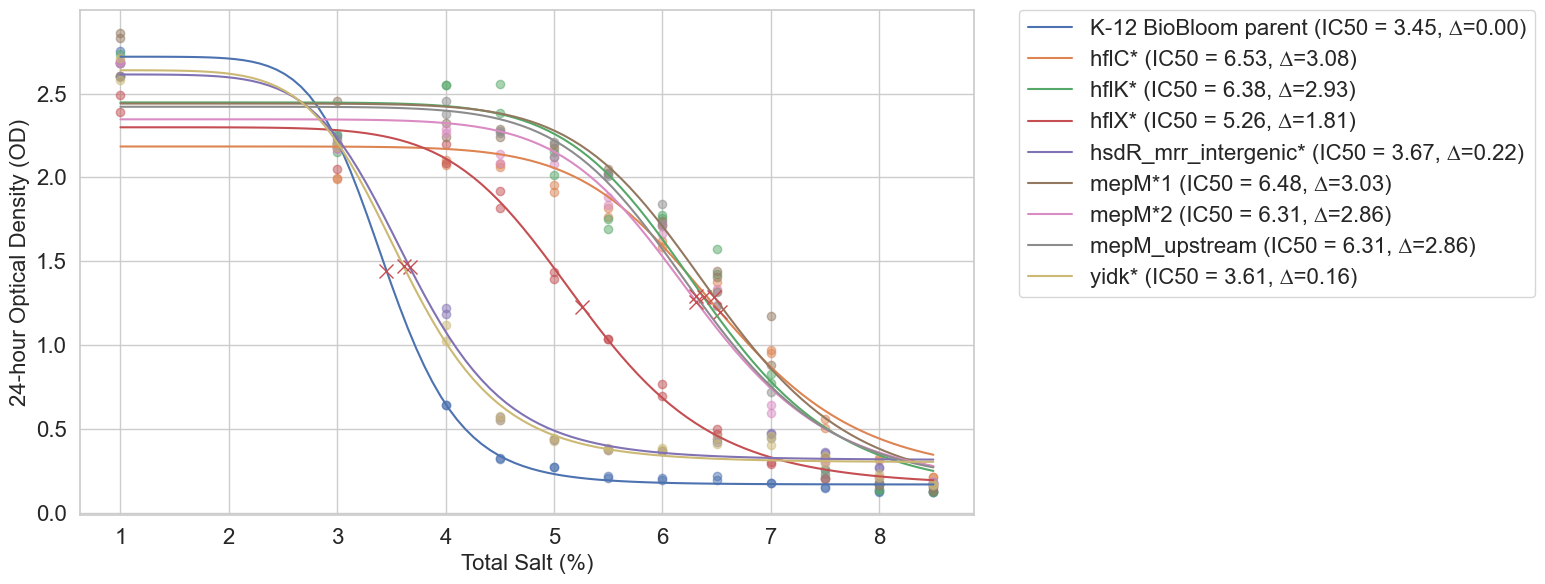

In [130]:
### filter data and perform "hill fit" for ic50 analysis, alongside plotting

#filter for now:
into_plot = annotated_df[annotated_df['innoculum']=="LB_innoc"] #LB_innoc
#for publication, omit K-12 base strain and plasmid overexpression strain, which are internal controls.
into_plot = into_plot[~into_plot['strain'].isin(["s.Ek.E.00157","s.Ek.E.00994"])]

# Use seaborn for color palette
strain_order = sorted(into_plot['strain'].unique())  # Define consistent hue order
palette = sns.color_palette("colorblind", into_plot['strain'].nunique())

### used to calculate delta IC50
HARDCODED_PARENT_IC50_VALUE = 3.45

# 4PL model
def four_param_logistic(x, a, b, c, d):
    return d + (a - d) / (1 + (x / c)**b)


# Store IC50 results
results = []

plt.figure(figsize=(10, 6))

# Define bounds
# A = Top asymptote (max OD)
# B = Hill slope
# C = IC50
# D = Bottom asymptote (min OD)


# Loop through each strain
for label, subdf in into_plot.groupby('label'):
    xdata = subdf['total_salt_pct'].values
    ydata = subdf['true_OD'].values

    #set bounds
    bounds_lower = [1.0, 0, 0.0,  min(ydata)]     # A, B, C, D
    bounds_upper = [5.0, 10.0, 10.0, 1.0] 
    
    sort_idx = np.argsort(xdata)
    xdata, ydata = xdata[sort_idx], ydata[sort_idx]

    p0 = [max(ydata), 1, np.median(xdata), min(ydata)]

    try:
        popt, pcov = curve_fit(
            four_param_logistic,
            xdata,
            ydata,
            bounds=(bounds_lower, bounds_upper)
        )
        a, b, ic50, d = popt
        delta_ic50 = ic50 - HARDCODED_PARENT_IC50_VALUE ##### 

        #add uncertainty
        ic50_se = np.sqrt(np.diag(pcov))[2] #compute standard error of IC50 fit
        ic50_95ci = 1.96 * ic50_se #95% confidence interval spread

        results.append({'label': label, 'IC50': ic50, '∆IC50': delta_ic50, 'IC50_sd': ic50_se, 'IC50_95ci': ic50_95ci})

        xfit = np.linspace(min(xdata), max(xdata), 100)
        yfit = four_param_logistic(xfit, *popt)
        plt.plot(xfit, yfit, label=f"{label} (IC50 = {ic50:.2f}, ∆={delta_ic50:.2f})")
        plt.scatter(xdata, ydata, alpha=0.5)

        # Add red X at IC50
        y_ic50 = four_param_logistic(ic50, *popt)
        plt.plot(ic50, y_ic50, 'rx', markersize=10, label=None)

    except RuntimeError:
        print(f"Curve fitting failed for {label}")
        results.append({'strain': label, 'IC50': np.nan, '∆IC50': np.nan, 'IC50_sd': np.nan})


font_size = 16
plt.xlabel("Total Salt (%)", fontsize=font_size)
plt.ylabel("24-hour Optical Density (OD)", fontsize=font_size)
plt.tick_params(labelsize=font_size)
plt.grid(True)
plt.tight_layout()
plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=font_size)


plt.savefig(os.path.join(fig_out, 'figure5_biobloom_inhibition_curves.png'), dpi=600, bbox_inches="tight")
plt.show()

# Save as dataframe
ic50_df = pd.DataFrame(results)

In [ ]:
## save dataframe to disk
ic50_df.to_csv(os.path.join(fig_out, 'figure5_biobloom_ic50_values.csv'), index=False)

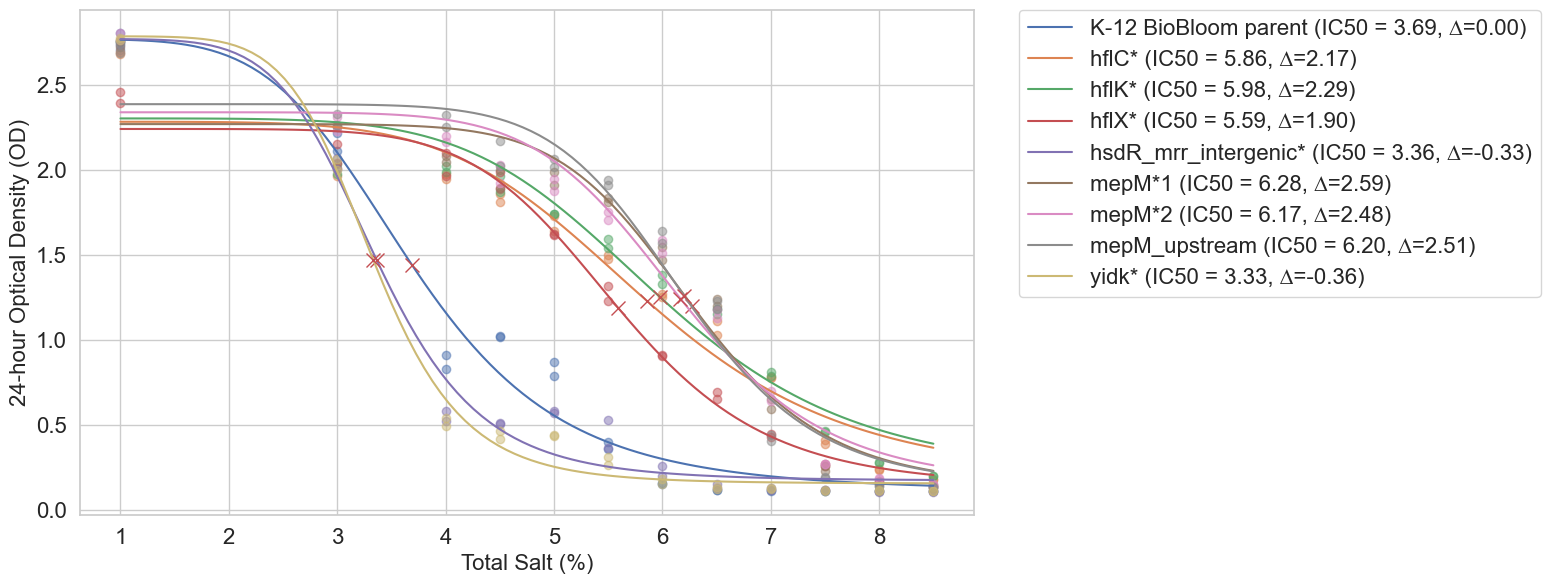

In [132]:
# try for acclimated conditions
### filter data and perform "hill fit" for ic50 analysis, alongside plotting

#filter for now:
into_plot = annotated_df[annotated_df['innoculum']=="LB+2pct_innoc"] #LB_innoc
#for publication, omit K-12 base strain and plasmid overexpression strain, which are internal controls.
into_plot = into_plot[~into_plot['strain'].isin(["s.Ek.E.00157","s.Ek.E.00994"])]

# Use seaborn for color palette
strain_order = sorted(into_plot['strain'].unique())  # Define consistent hue order
palette = sns.color_palette("colorblind", into_plot['strain'].nunique())

### used to calculate delta IC50
HARDCODED_PARENT_IC50_VALUE = 3.69

# 4PL model
def four_param_logistic(x, a, b, c, d):
    return d + (a - d) / (1 + (x / c)**b)


# Store IC50 results
results = []

plt.figure(figsize=(10, 6))

# Define bounds
# A = Top asymptote (max OD)
# B = Hill slope
# C = IC50
# D = Bottom asymptote (min OD)


# Loop through each strain
for label, subdf in into_plot.groupby('label'):
    xdata = subdf['total_salt_pct'].values
    ydata = subdf['true_OD'].values

    #set bounds
    bounds_lower = [1.0, 0, 0.0,  min(ydata)]     # A, B, C, D
    bounds_upper = [5.0, 10.0, 10.0, 1.0] 
    
    sort_idx = np.argsort(xdata)
    xdata, ydata = xdata[sort_idx], ydata[sort_idx]

    p0 = [max(ydata), 1, np.median(xdata), min(ydata)]

    try:
        popt, pcov = curve_fit(
            four_param_logistic,
            xdata,
            ydata,
            bounds=(bounds_lower, bounds_upper)
        )
        a, b, ic50, d = popt
        delta_ic50 = ic50 - HARDCODED_PARENT_IC50_VALUE ##### 

        #add uncertainty
        ic50_se = np.sqrt(np.diag(pcov))[2] #compute standard error of IC50 fit
        ic50_95ci = 1.96 * ic50_se #95% confidence interval spread
        results.append({'label': label, 'IC50': ic50, '∆IC50': delta_ic50, 'IC50_sd': ic50_se, 'IC50_95ci': ic50_95ci})

        xfit = np.linspace(min(xdata), max(xdata), 100)
        yfit = four_param_logistic(xfit, *popt)
        plt.plot(xfit, yfit, label=f"{label} (IC50 = {ic50:.2f}, ∆={delta_ic50:.2f})")
        plt.scatter(xdata, ydata, alpha=0.5)

        # Add red X at IC50
        y_ic50 = four_param_logistic(ic50, *popt)
        plt.plot(ic50, y_ic50, 'rx', markersize=10, label=None)

    except RuntimeError:
        print(f"Curve fitting failed for {label}")
        results.append({'strain': label, 'IC50': np.nan, '∆IC50': np.nan})


font_size = 16
plt.xlabel("Total Salt (%)", fontsize=font_size)
plt.ylabel("24-hour Optical Density (OD)", fontsize=font_size)
plt.tick_params(labelsize=font_size)
plt.grid(True)
plt.tight_layout()
plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=font_size)


plt.savefig(os.path.join(fig_out, 'figure5_biobloom_inhibition_curves_acclimated.png'), dpi=600, bbox_inches="tight")
plt.show()

# Save as dataframe
ic50acclimated_df = pd.DataFrame(results)

In [133]:
#get raw data for ALE strains
ale_inhibition_data_path = os.path.join(data_dir, "ALE_inhibition_curves_raw_data.csv")
ale_inhibition_data = pd.read_csv(ale_inhibition_data_path)
#ale_inhibition_data.info()

#label ale strains
ale_inhibition_labeled = pd.merge(ale_inhibition_data, strainlabels, on = ['strain'])

#true OD, total salt
ale_inhibition_labeled['true_OD'] = ale_inhibition_labeled['OD'] * 3 #3x dilution
ale_inhibition_labeled['total_salt_pct'] = ale_inhibition_labeled['added_salt_pct'] + 1
#ale_inhibition_labeled.info()
ale_inhibition_labeled

,plate,well,OD,added_salt_pct,strain,Experiment,Experiment Date,label,true_OD,total_salt_pct
0,1,A01,0.6938,0.00,s.Ec.E.1058,CET-009,9/10/25,K-12 ALE parent,2.0814,1.00
1,1,A02,0.6562,1.00,s.Ec.E.1058,CET-009,9/10/25,K-12 ALE parent,1.9686,2.00
2,1,A03,0.6158,2.00,s.Ec.E.1058,CET-009,9/10/25,K-12 ALE parent,1.8474,3.00
3,1,A04,0.5401,2.50,s.Ec.E.1058,CET-009,9/10/25,K-12 ALE parent,1.6203,3.50
4,1,A05,0.4113,2.75,s.Ec.E.1058,CET-009,9/10/25,K-12 ALE parent,1.2339,3.75
...,...,...,...,...,...,...,...,...,...,...
1531,16,H08,0.0849,6.50,s.Ek.E.01388,CET-009,9/10/25,mepM*1,0.2547,7.50
1532,16,H09,0.0475,7.00,s.Ek.E.01388,CET-009,9/10/25,mepM*1,0.1425,8.00
1533,16,H10,0.0404,8.00,s.Ek.E.01388,CET-009,9/10/25,mepM*1,0.1212,9.00
1534,16,H11,0.0419,9.00,s.Ek.E.01388,CET-009,9/10/25,mepM*1,0.1257,10.00


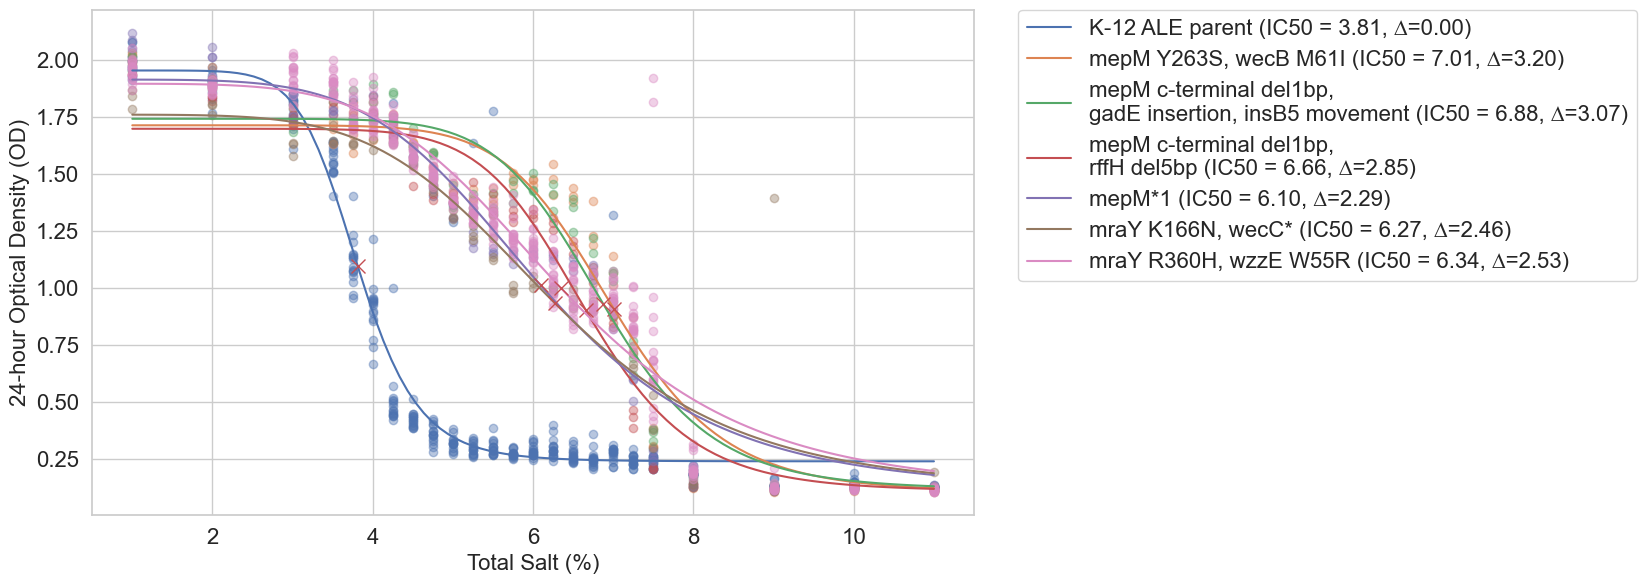

In [174]:
#compute ic50 etc for ale strains
### filter data and perform "hill fit" for ic50 analysis, alongside plotting

#filter for now:
into_plot = ale_inhibition_labeled.copy() #@.info()
into_plot = into_plot[~into_plot['label'].isin(["not_sequenced"])] #remove unsequenced strains, biobloom internal comparison/control

#split labels where names are long
replacements = {
    "mepM c-terminal del1bp, gadE insertion, insB5 movement":
        "mepM c-terminal del1bp,\ngadE insertion, insB5 movement",
    "mepM c-terminal del1bp, rffH del5bp":
        "mepM c-terminal del1bp,\nrffH del5bp"}
into_plot['label'] = into_plot['label'].replace(replacements)

# Use seaborn for color palette
strain_order = sorted(into_plot['label'].unique())  # Define consistent hue order
palette = sns.color_palette("colorblind", into_plot['label'].nunique())

### used to calculate delta IC50
HARDCODED_PARENT_IC50_VALUE = 3.81

# 4PL model
def four_param_logistic(x, a, b, c, d):
    return d + (a - d) / (1 + (x / c)**b)


# Store IC50 results
results = []

plt.figure(figsize=(10, 6))

# Define bounds
# A = Top asymptote (max OD)
# B = Hill slope
# C = IC50
# D = Bottom asymptote (min OD)


# Loop through each strain
for label, subdf in into_plot.groupby('label'):
    xdata = subdf['total_salt_pct'].values
    ydata = subdf['true_OD'].values

    #set bounds
    bounds_lower = [1.0, 0, 0.0,  min(ydata)]     # A, B, C, D
    bounds_upper = [5.0, 10.0, 10.0, 1.0] 
    
    sort_idx = np.argsort(xdata)
    xdata, ydata = xdata[sort_idx], ydata[sort_idx]

    p0 = [max(ydata), 1, np.median(xdata), min(ydata)]

    try:
        popt, pcov = curve_fit(
            four_param_logistic,
            xdata,
            ydata,
            bounds=(bounds_lower, bounds_upper)
        )
        a, b, ic50, d = popt
        delta_ic50 = ic50 - HARDCODED_PARENT_IC50_VALUE #####


        #add uncertainty
        ic50_se = np.sqrt(np.diag(pcov))[2] #compute standard error of IC50 fit
        ic50_95ci = 1.96 * ic50_se #95% confidence interval spread

        results.append({'label': label, 'IC50': ic50, '∆IC50': delta_ic50, 'IC50_sd': ic50_se, 'IC50_95ci': ic50_95ci})

        xfit = np.linspace(min(xdata), max(xdata), 100)
        yfit = four_param_logistic(xfit, *popt)
        plt.plot(xfit, yfit, label=f"{label} (IC50 = {ic50:.2f}, ∆={delta_ic50:.2f})")
        plt.scatter(xdata, ydata, alpha=0.4)

        # Add red X at IC50
        y_ic50 = four_param_logistic(ic50, *popt)
        plt.plot(ic50, y_ic50, 'rx', markersize=10, label=None)

    except RuntimeError:
        print(f"Curve fitting failed for {label}")
        results.append({'strain': label, 'IC50': np.nan, '∆IC50': np.nan, 'IC50_sd': np.nan})


font_size = 16
plt.xlabel("Total Salt (%)", fontsize=font_size)
plt.ylabel("24-hour Optical Density (OD)", fontsize=font_size)
plt.tick_params(labelsize=font_size)
plt.grid(True)
plt.tight_layout()
plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=font_size)


plt.savefig(os.path.join(fig_out, 'ALE_inhibition_curves.png'), dpi=600, bbox_inches="tight")
plt.show()

# Save as dataframe
ic50_ale_df = pd.DataFrame(results)

In [175]:
#append ale to BB data for plotting

ic50_ale_df = ic50_ale_df[ic50_ale_df['label']!='mepM*1'] #omit internal comparison/control
ic50_ale_df['type'] = 'ALE'

ic50_df['type'] = 'BioBloom'

combined_ic50_df = pd.concat([ic50_df, ic50_ale_df])

combined_ic50_df #['label'].unique()


,label,IC50,∆IC50,IC50_sd,IC50_95ci,type
0,K-12 BioBloom parent,3.454277,0.004277,0.017584,0.034465,BioBloom
1,hflC*,6.529158,3.079158,0.206122,0.403999,BioBloom
2,hflK*,6.379802,2.929802,0.194648,0.381511,BioBloom
3,hflX*,5.262351,1.812351,0.060561,0.118701,BioBloom
4,hsdR_mrr_intergenic*,3.669310,0.219310,0.063994,0.125427,BioBloom
5,mepM*1,6.480253,3.030253,0.187548,0.367593,BioBloom
6,mepM*2,6.311473,2.861473,0.154193,0.302218,BioBloom
7,mepM_upstream,6.313138,2.863138,0.149010,0.292060,BioBloom
8,yidk*,3.611514,0.161514,0.054956,0.107714,BioBloom
0,K-12 ALE parent,3.811541,0.001541,0.027788,0.054464,ALE


In [176]:
#build custom color palette for plotting

custom_palette = {}
biobloom_palette = {
    "K-12 BioBloom parent": "blue",
    "hflC*": "orange",
    "hflK*": "orange",
    "hflX*": "orange",
    "hsdR_mrr_intergenic*": "red",
    "mepM*1": "green",
    "mepM*2": "green",
    "mepM_upstream": "green",
    "yidk*": "red",
}
custom_palette.update(biobloom_palette)

ale_colors = ['grey']*6
ale_palette = {
    'mepM Y263S, wecB M61I': ale_colors[0],
    'mepM c-terminal del1bp,\ngadE insertion, insB5 movement': ale_colors[1],
    'mepM c-terminal del1bp,\nrffH del5bp': ale_colors[2],
    'mraY K166N, wecC*': ale_colors[3],
    'mraY R360H, wzzE W55R': ale_colors[4],
    'K-12 ALE parent': "blue",
}
custom_palette.update(ale_palette)

/Users/Max_Schubert/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  func(*plot_args, **plot_kwargs)
/Users/Max_Schubert/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  func(*plot_args, **plot_kwargs)
/Users/Max_Schubert/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  func(*plot_args, **plot_kwargs)
/Users/Max_Schubert/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  func(*plot_args, **plot_kwar

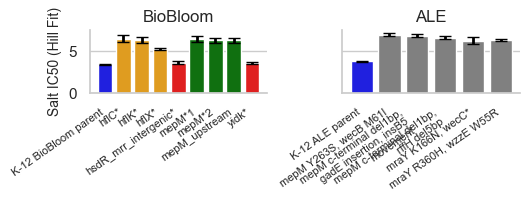

In [154]:
#plot setup
import textwrap

into_plot = combined_ic50_df.copy()

sns.set(style="whitegrid")


g = sns.FacetGrid(
    into_plot,
    col="type",
    col_wrap=2,        # 1×2
    height=2,
    aspect=1.5,
    sharey=True,
    sharex=False
)

g.map_dataframe(
    sns.barplot,
    x="label",
    y="IC50",
    hue="label",
    errcolor="black",
    errwidth=2,
    palette=custom_palette,
    dodge=False,
    errorbar=None   #overlaying error bars below
)

#errorbars
for ax, facet_type in zip(g.axes.flat, g.col_names):
    subdf = into_plot[into_plot["type"] == facet_type]

    for _, row in subdf.iterrows():
        ax.errorbar(
            x=row["label"],
            y=row["IC50"],
            yerr=row["IC50_95ci"],
            fmt="none",
            ecolor="black",
            elinewidth=2,
            capsize=4,
            zorder=10
        )

##formatting plot
fontsize = 10

g.set_titles("{col_name}", fontsize=fontsize)
g.set_axis_labels("", "Salt IC50 (Hill Fit)", fontsize=fontsize)
for ax in g.axes.flat:
    ax.set_xticklabels(
        [textwrap.fill(t.get_text(), 25) for t in ax.get_xticklabels()],
        rotation=35,
        ha="right",
        fontsize=fontsize-2,
    )
    ax.set_ylim(bottom=0)   # optional


#plt.savefig(os.path.join(fig_out, 'figure5_ic50_comparison.png'), dpi=600, bbox_inches="tight")

/Users/Max_Schubert/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


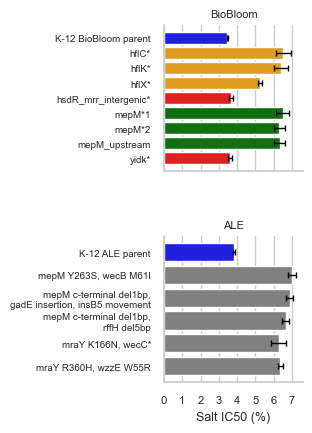

In [179]:
#try alternative with horizontal barH
into_plot = combined_ic50_df.copy()
g = sns.FacetGrid(
    into_plot,
    col="type",
    col_wrap=1,
    height=2.2,
    aspect=1,
    sharex=True,     # compare IC50 across types
    sharey=False     # labels differ per facet
)

g.map_dataframe(
    sns.barplot,
    y="label",
    x="IC50",
    hue="label",
    palette=custom_palette,
    dodge=False,
    errorbar=None
)

#x_errorbar
for ax, facet_type in zip(g.axes.flat, g.col_names):
    subdf = into_plot[into_plot["type"] == facet_type]

    for _, row in subdf.iterrows():
        ax.errorbar(
            x=row["IC50"],
            y=row["label"],
            xerr=row["IC50_95ci"],   # <-- horizontal CI
            fmt="none",
            ecolor="black",
            elinewidth=1,
            capsize=2,
            zorder=10
        )

#plot setup
fontsize = 9
xticks = np.arange(0, 8, 1) 
g.set_axis_labels("Salt IC50 (%)", "", fontsize=fontsize)
#set titlenames, size
for ax, title in zip(g.axes.flat, g.col_names):
    ax.set_title(title, fontsize=fontsize-1)


for ax in g.axes.flat:
    ax.tick_params(axis="y", labelsize=fontsize-2)
    ax.tick_params(axis="x", labelsize=fontsize-1)
    ax.set_xticks(xticks)
    ax.set_xlim(left=0)

plt.savefig(os.path.join(fig_out, 'figure5_ic50_comparison_horizontal.pdf'), dpi=600, bbox_inches="tight")
